Written by Ye-seul Oh. 

# <span style="color:blue">1 SMILES 로부터 HOMO-LUMO gap 예측  ~ **<< Confromation of molecules >>** </span> 


###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. **전체 dataset을 준비**
2. **X , y 분리**
3. traing set , test set 분리
---
4. 빈 모델을 만듦   
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄 
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter

↓ 먼저 파일을 .csv 파일을 불러와서 dataframe을 만든다. (엑셀에서 .csv 파일로 저장)

In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
chart = pd.read_csv('PubchemQC_Random_HOMO-LUMO_gap_and_OS.csv')

In [2]:
chart

,#HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,4.603,0.053,CC(C)(C1=CC(=C(C=C1)F)N2CCNCC2)O
1,3.980,0.002,CC1CC(C(=O)C(O1)C)(C)N
2,4.958,0.003,CC1(CC(CC(N1O)(C)C)[N+](C)(C)C)C
3,4.822,0.065,C1=CC(=C(C=C1CC(C(=O)O)N)O)O
4,4.104,0.110,CC(CNC1=NC=NC2=CC=CC=C21)C(=O)O
...,...,...,...
99995,5.333,0.003,CN1CCCC1C(=O)NCC2CCCO2
99996,4.448,0.002,C1COC(=N)N=C1
99997,3.606,0.000,CC12CCC(=O)C=C1CCC3C2CCC4(C3CCC4(C#C)O)C
99998,0.000,0.000,C(CO)NC[CH]O


↓ 각각 column들을 리스트에 넣어준다.

In [3]:
gap = [i for i in chart['#HOMO-LUMO_gap(eV)']]
os = [i for i in chart['Oscillator_Strength']]
smiles = [i for i in chart['SMILES']]

↓ SMILES를 mol type으로 변환 후 H를 붙여 새로운 리스트에 저장한다.

In [4]:
smiles_H=[]
for smi in smiles:
    m = Chem.MolFromSmiles(smi)
    smiles_H.append(Chem.AddHs(m))

↓ 수소를 붙인 분자들의 3D 구조를 생성한다.

In [45]:
from rdkit.Chem import AllChem
for m in smiles_H:
    AllChem.EmbedMolecule(m)        # 실행이 너무 느리다.

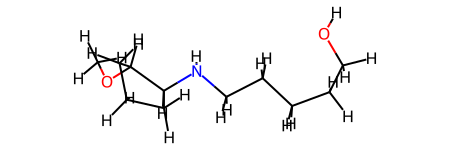

In [48]:
smiles_H[1992]

↓  ~결과는 상당히 rough한 값이기 때문에  MMFF force-filed 최적화 함수로 구조를 최적화 해준다.~ ......... for문이 안돌아간다.

In [50]:
for mol in smiles_H:
    AllChem.MMFFOptimizeMolecule(mol)

ValueError: Bad Conformer Id

↓ 분자 한개로는 실행이 되길래

In [51]:
AllChem.MMFFOptimizeMolecule(smiles_H[0])

0

↓ 분자 개수가 너무 큰가 싶어서 list범위를 1/10 씩 쪼개서 돌려보려고 했는데 안된다.

In [54]:
for i  in range(0,10000):
    AllChem.MMFFOptimizeMolecule(smiles_H[i])

ValueError: Bad Conformer Id

↑ 일단 이 과정은 생략해야겠다 :(

↓ 분자들의 Figerprints 를 얻는다. (성질 예측을 위해서는 ECFP interation 횟수 3~4번이 좋다고 알려져 있지만, 노트북 성능이 안좋아서 2번으로 설정했다.)

In [56]:
fp = []
for m in smiles_H:
    m_fp = AllChem.GetMorganFingerprint(m,2)
    fp.append(m_fp)

↓ Fingerprints를 BitVector로 얻는다. (AllChem모듈의 method가 실행이 안돼서 rdMolDescriptors 있는 같은 기능의 method로 실행)

In [63]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

fp_bit = []
for m in smiles_H:
    m_bit = GetMorganFingerprintAsBitVect(m,2,nBits=2048)
    fp_bit.append(m_bit)

↓ X (ECFP) 와 y (HOMO-LUMO gap) 생성 완료 !  

In [66]:
X = fp_bit
y = gap

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. **traing set , test set 분리**<span style="color:orange"> →  X_train, X_test, y_train, y_test</span>
---
4. 빈 모델을 만듦   
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄 
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter

↓  X_train, X_test, y_train, y_test 을 분리한다.

In [67]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=722)

In [95]:
type(X_test[0])

rdkit.DataStructs.cDataStructs.ExplicitBitVect

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. **빈 모델을 만듦**   <span style="color:orange">→    .RandomForestRegressor()</span> 
5. **빈 모델에 traing set을 넣어 모델을 학습시킴**<span style="color:orange"> → .fit()</span>
6. **학습된 모델에 test set을 넣어 예측시켜봄** <span style="color:orange">→ .predict()</span>
---
7. 잘 풀었나 채점해봄 
8. 모델 튜닝 Hypter parameter

↓ 빈 모델 생성 → 학습 → 예측 순서로 진행한다.

In [68]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

my_model = RandomForestRegressor()

In [ ]:
my_model.fit(X_train, y_train)     # 너.....어......무 느리다... 안된다... 계속 [*] 상태다...

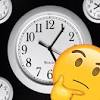 Hmmm...

In [72]:
my_model.fit(X_train[:10000], y_train[:10000])  # 결국 학습을 멈추고 1/10 씩 쪼개서 다시 실행하였다...

RandomForestRegressor()

In [73]:
my_model.fit(X_train[10001:20000], y_train[10001:20000])

RandomForestRegressor()

In [74]:
my_model.fit(X_train[20001:30000], y_train[20001:30000])

RandomForestRegressor()

In [76]:
my_model.fit(X_train[40001:50000], y_train[40001:50000])

RandomForestRegressor()

In [77]:
my_model.fit(X_train[50001:60000], y_train[50001:60000])

RandomForestRegressor()

In [78]:
my_model.fit(X_train[60001:70000], y_train[60001:70000])

RandomForestRegressor()

In [79]:
my_model.fit(X_train[70001:80000], y_train[70001:80000])

RandomForestRegressor()

In [ ]:
my_model.fit(X_train[80001:90000], y_train[80001:90000])      # 엥? 갑자기 웬 오류?

In [ ]:
my_model.fit(X_train[90001:100000], y_train[90001:100000])    # 에엥?

In [82]:
my_model.fit(X_train[90001:100000], y_train[90001:100000])    # 에엥?

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [83]:
y_pred = my_model.predict(X_test)

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦   
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄 
---
7. **잘 풀었나 채점해봄**
8. 모델 튜닝 Hypter parameter

↓ RMSE 구하기 (MSE에 루트를 취함)

In [85]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.605304453024637

↑ RMSE가 꽤 크다. MMFF force field 최적화 함수를 적용했다면 어떤 값이 나왔을 지 궁금하다.

↓  그래프 그려보기

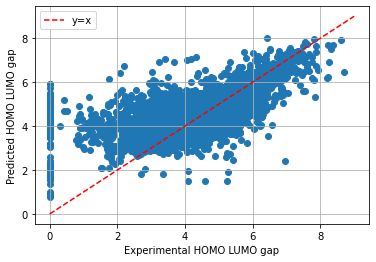

In [88]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.scatter(y_test, y_pred)
plt.xlabel("Experimental HOMO LUMO gap")
plt.ylabel("Predicted HOMO LUMO gap")
plt.grid()
plt.plot(range(0, 10), range(0, 10), "r--", label = "y=x")
plt.legend()

###  <span style="color:orange">Maching Learning 기본 순서 </span>
1. 전체 dataset을 준비
2. X , y 분리
3. traing set , test set 분리
---
4. 빈 모델을 만듦   
5. 빈 모델에 traing set을 넣어 모델을 학습시킴
6. 학습된 모델에 test set을 넣어 예측시켜봄 
---
7. 잘 풀었나 채점해봄
8. **모델 튜닝 Hypter parameter**

↓ trainig 한번 돌리는데도 엄청난 시간이 소요돼서 이 과정은 생략할 수 밖에 없었다... :(

In [ ]:
min_rmse = 1.0
for est in [50,100,150,200,250,300]:      
        for spl in [2,3,4]:
            model = RandomForestRegressor(n_estimators = est ,min_samples_split = spl)
            model.fit(X_train[:], y_train[:])       # 학습
            y_pred = model.predict(X_test)    # 예측
            rmse = sqrt(mean_squared_error(y_test, y_pred))   # RMSE                          
            if rmse < min_rmse:          
                min_rmse = rmse          #오차가 가장 작아지게 하는
                n_estimators = est       # hyper parameter 찾기
                min_samples_split = spl
            
        print(f"n_estimators: {est}\tmin_samples_split: {spl}\trmse: {rmse}")
print("-----------------End of Calculation!-----------------")
print(f"Optimal result! n_estimators: {n_estimators}\tmin_samples_split: {min_samples_split}\trmse: {min_rmse}")

Machine Learning 끝!

### <span style="color:blue">테스트용 SMILES 데이터로 HOMO-LUMO gap 값을 예측해보자!</span>   

↓ 주어진 테스트용 파일을 읽어서 mol type으로 바꾸고, 수소 붙이고, 3차원구조 생성하고

In [90]:
real_test = []
for smi in open('SMILES_for_test.txt').readlines():   
    m = Chem.MolFromSmiles(smi)
    real_test.append(Chem.AddHs(m))

In [92]:
for m in real_test:
    AllChem.EmbedMolecule(m)

↓ Fingerprints를 BitVector로 얻고, 예측값 얻는다.

In [96]:
real_test_bit=[]
for m in real_test:
    m_bit = GetMorganFingerprintAsBitVect(m,2,nBits=2048)
    real_test_bit.append(m_bit)
    
real_pred = my_model.predict(real_test_bit)

- 전체 예측값 dataframe

In [101]:
real_test_smi = []
for i in real_test:
    m = Chem.MolToSmiles(i)
    real_test_smi.append(m)

result = {"SMILES": real_test_smi ,"H_L gap 예측값(eV)": real_pred }
dataframe = pd.DataFrame(result)
dataframe

,SMILES,H_L gap 예측값(eV)
0,[H]OC1(S(=O)(=O)O[H])C(=O)C([H])([H])C([H])([H...,4.13547
1,[H]C([H])([H])C(=O)C([H])([H])C([H])([H])C([H]...,4.76590
2,[H]OS(=O)N([H])C([H])([H])C([H])([H])C1([H])N(...,5.04144
3,[H]c1c([H])c([H])c(C([H])([H])C([H])([H])[H])c...,4.99609
4,[H]OC([H])([H])c1c(C2([H])C([H])([H])C2([H])[H...,5.41609
...,...,...
9995,[H]c1c([H])c([H])c2c(c1[H])C([H])([H])C1([H])N...,4.82532
9996,[H]N=c1c2c([H])c([H])c([H])c([H])c2nc([H])n1-c...,3.84534
9997,[H]c1nc(C(=O)OC(C([H])([H])[H])(C([H])([H])[H]...,4.21902
9998,[H]c1nc(N(C([H])([H])C([H])([H])C([H])([H])C([...,3.93678


- 예측값을 반환하는 함수 

In [ ]:
def convert():
    user = input("몇 번째 분자의 HOMO-LUMO gap 예측값이 궁금한가요? :")
    x = int(user)
    y= real_pred[x-1]
    s= real_test_smi[x-1]

    return print(f"{x} 번째 분자의 HOMO-LUMO gap 예측값은? : {y}eV 입니다! :D \n SMILES:{s}")
convert()

### <span style="color:blue">이번엔 Oscillator strength 값을 예측해보자 !</span>

In [116]:
X2 = fp_bit
y2 = os

 **여기서부터 파이썬이 멈춰버렸다..**  
↓ 데이터셋 나누고, 빈 모델 생성하고, 학습, 예측 !

In [ ]:
X2_train, X2_test, y2_train, y2_test = sklearn.model_selection.train_test_split(X2, y2, test_size=0.2, random_state=722)

In [ ]:
my_model2 = RandomForestRegressor()
my_model2.fit(X2_train, y2_train)

In [ ]:
y2_pred = my_model2.predict(X2_test)

↓ RMSE 값 구하기

In [ ]:
rmse2 = sqrt(mean_squared_error(y2_test, y2_pred))
rmse2

↓ 그래프 그리기~

In [ ]:
plt.scatter(y2_test, y2_pred)
plt.xlabel("Experimental Oscillator strength")
plt.ylabel("Predicted Oscillator strength")
plt.grid()
plt.plot(range(0, 1), range(0, 1), "r--", label = "y=x")
plt.legend()

↓ 주어진 테스트용 데이터('SMILES_for_test.txt)의 scillator strength 값을 예측시켰다.

In [ ]:
real_pred2 = my_model2.predict(real_test)

- 전체 예측값 dataframe

In [ ]:
result2 = {"SMILES": real_test_smi ,"Oscillator strength 예측값": real_pred2 }
dataframe2 = pd.DataFrame(result)

- 예측값을 반환하는 함수

In [ ]:
def convert2():
    user = input("몇 번째 분자의 Oscillator strength 예측값이 궁금한가요?:")
    x = int(user)
    y= real_pred2[x-1]
    s= real_test_smi[x-1]

    return print(f"{x} 번째 분자의 Oscillator strength 예측값은?: {y} 입니다 :D \n SMILES:{s}")
convert2()